In [65]:
from datetime import datetime
from geopy import Nominatim
from tzwhere import tzwhere
from pytz import timezone, utc

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.patches import Circle

from skyfield.api import Star, load, wgs84
from skyfield.data import hipparcos, mpc, stellarium
from skyfield.projections import build_stereographic_projection
from skyfield.constants import GM_SUN_Pitjeva_2005_km3_s2 as GM_SUN

import warnings
warnings.filterwarnings("ignore")

In [66]:
def load_data():
    # load celestial data
    # de421 shows position of earth and sun in space
    eph = load('de421.bsp')

    # hipparcos dataset contains star location data
    with load.open(hipparcos.URL) as f:
        stars = hipparcos.load_dataframe(f)

    # And the constellation outlines come from Stellarium.  We make a list
    # of the stars at which each edge stars, and the star at which each edge
    # ends.

    url = ('https://raw.githubusercontent.com/Stellarium/stellarium/master'
           '/skycultures/modern_st/constellationship.fab')

    with load.open(url) as f:
        constellations = stellarium.parse_constellations(f)
        
    return eph, stars, constellations

In [67]:
def load_data_cam(url_path="../data/cam.constellationship.fab"):
    # load celestial data
    # de421 shows position of earth and sun in space
    eph = load('de421.bsp')

    # hipparcos dataset contains star location data
    with load.open(hipparcos.URL) as f:
        stars = hipparcos.load_dataframe(f)

    # And the constellation outlines come from Stellarium.  We make a list
    # of the stars at which each edge stars, and the star at which each edge
    # ends.

    url = (url_path)

    with load.open(url) as f:
        constellations = stellarium.parse_constellations(f)
        
    return eph, stars, constellations

In [68]:
def collect_celestial_data(location, when):
    # get latitude and longitude of our location 
    locator = Nominatim(user_agent='myGeocoder')
    location = locator.geocode(location)
    lat, long = location.latitude, location.longitude
    
    # convert date string into datetime object
    dt = datetime.strptime(when, '%Y-%m-%d %H:%M')

    # define datetime and convert to utc based on our timezone
    timezone_str = tzwhere.tzwhere().tzNameAt(lat, long)
    local = timezone(timezone_str)

    # get UTC from local timezone and datetime
    local_dt = local.localize(dt, is_dst=None)
    utc_dt = local_dt.astimezone(utc)

    # load celestial data
    # eph, stars, constellations = load_data()

    # find location of earth and sun and set the observer position
    sun = eph['sun']
    earth = eph['earth']

    # define observation time from our UTC datetime
    ts = load.timescale()
    t = ts.from_datetime(utc_dt)

    # define an observer using the world geodetic system data
    observer = wgs84.latlon(latitude_degrees=lat, longitude_degrees=long).at(t)

    # define the position in the sky where we will be looking
    position = observer.from_altaz(alt_degrees=90, az_degrees=0)
    # center the observation point in the middle of the sky
    ra, dec, distance = observer.radec()
    center_object = Star(ra=ra, dec=dec)

    # find where our center object is relative to earth and build a projection with 180 degree view
    center = earth.at(t).observe(center_object)
    projection = build_stereographic_projection(center)
    field_of_view_degrees = 180.0

    # calculate star positions and project them onto a plain space
    star_positions = earth.at(t).observe(Star.from_dataframe(stars))
    stars['x'], stars['y'] = projection(star_positions)
    
    edges = [edge for name, edges in constellations for edge in edges]
    edges_star1 = [star1 for star1, star2 in edges]
    edges_star2 = [star2 for star1, star2 in edges]

    
    return stars, edges_star1, edges_star2

In [69]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from datetime import datetime

def add_cam(location, when, chart_size, max_star_size, fig, ax):
    stars, edges_star1, edges_star2 = collect_celestial_data(location, when)
    limiting_magnitude = 10
    bright_stars = (stars.magnitude <= limiting_magnitude)
    magnitude = stars['magnitude'][bright_stars]
    # fig, ax = plt.subplots(figsize=(chart_size, chart_size))
    
    #use the night sky color code
    border = plt.Circle((0, 0), 1, color='#041A40', fill=True) 
    ax.add_patch(border)

    marker_size = max_star_size * 10 ** (magnitude / -2.5)

    ax.scatter(stars['x'][bright_stars], stars['y'][bright_stars],
               s=marker_size, color='red', marker='.', linewidths=0,
               zorder=2)
    # Draw the constellation lines.
    xy1 = stars[['x', 'y']].loc[edges_star1].values
    xy2 = stars[['x', 'y']].loc[edges_star2].values
    lines_xy = np.rollaxis(np.array([xy1, xy2]), 1)

    ax.add_collection(LineCollection(lines_xy, colors='red', linewidths=0.15))
    return fig, ax

def create_star_chart(location, when, chart_size, max_star_size):
    stars, edges_star1, edges_star2 = collect_celestial_data(location, when)
    limiting_magnitude = 10
    bright_stars = (stars.magnitude <= limiting_magnitude)
    magnitude = stars['magnitude'][bright_stars]
    fig, ax = plt.subplots(figsize=(chart_size, chart_size))
    
    #use the night sky color code
    border = plt.Circle((0, 0), 1, color='#041A40', fill=True) 
    ax.add_patch(border)

    marker_size = max_star_size * 10 ** (magnitude / -2.5)

    ax.scatter(stars['x'][bright_stars], stars['y'][bright_stars],
               s=marker_size, color='white', marker='.', linewidths=0,
               zorder=2)
    # Draw the constellation lines.
    xy1 = stars[['x', 'y']].loc[edges_star1].values
    xy2 = stars[['x', 'y']].loc[edges_star2].values
    lines_xy = np.rollaxis(np.array([xy1, xy2]), 1)
    print(edges_star1)
    
    print(stars[['x', 'y']].loc[edges_star1])
    
    ax.add_collection(LineCollection(lines_xy, colors='#ffff', linewidths=0.15))
    fig, ax = add_cam(location, when, chart_size, max_star_size, fig, ax)
    # if lines_xy in [23040, 23522, 23522, 22783, 22783, 29997, 29997, 33694, 33694, 29997, 29997, 22783, 22783, 17959, 17959, 17884, 17884, 16228]:
    #     ax.add_collection(LineCollection(lines_xy, colors='#red', linewidths=0.15))

    horizon = Circle((0, 0), radius=1, transform=ax.transData)
    for col in ax.collections:
        col.set_clip_path(horizon)

    # other settings
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    plt.axis('off')
    when_datetime = datetime.strptime(when, '%Y-%m-%d %H:%M')
    plt.title(f"Observation Location: {location}, Time: {when_datetime.strftime('%Y-%m-%d %H:%M')}", loc='right', fontsize=10)
   

    plt.show()

In [70]:
# load celestial data
eph, stars, constellations = load_data()
eph_cam, stars_cam, constellations_cam = load_data_cam()

In [71]:
constellations[10]

('CMi', [(37279, 36188)])

[677, 3092, 5447, 113726, 116631, 116805, 116584, 116805, 116631, 1473, 2912, 3092, 2912, 5447, 4436, 3881, 5434, 3092, 3031, 3693, 53502, 51172, 72370, 80047, 81852, 98036, 97649, 97278, 95501, 93805, 95501, 93747, 95501, 97804, 93244, 93805, 99473, 96468, 93805, 102618, 106278, 109074, 110395, 110960, 111497, 110960, 110672, 109139, 106278, 109074, 110003, 112961, 114724, 115033, 115438, 115033, 114341, 115033, 113136, 112716, 85267, 85727, 82363, 83081, 83153, 85792, 88714, 85792, 8832, 8903, 9884, 25428, 23015, 23767, 24608, 28360, 28380, 23767, 23453, 23416, 24608, 28358, 69673, 72105, 74666, 73555, 71075, 71053, 69673, 67927, 69673, 71075, 69732, 70497, 69483, 30324, 32349, 34444, 33579, 34444, 30324, 31592, 33152, 32349, 33347, 34045, 33160, 37279, 63125, 23595, 21861, 21770, 23040, 23522, 22783, 29997, 33694, 29997, 22783, 17959, 17884, 100064, 100345, 102485, 102978, 105881, 106723, 107556, 106985, 104139, 30438, 45238, 50099, 52419, 51576, 50371, 45556, 51576, 52419, 54301, 5

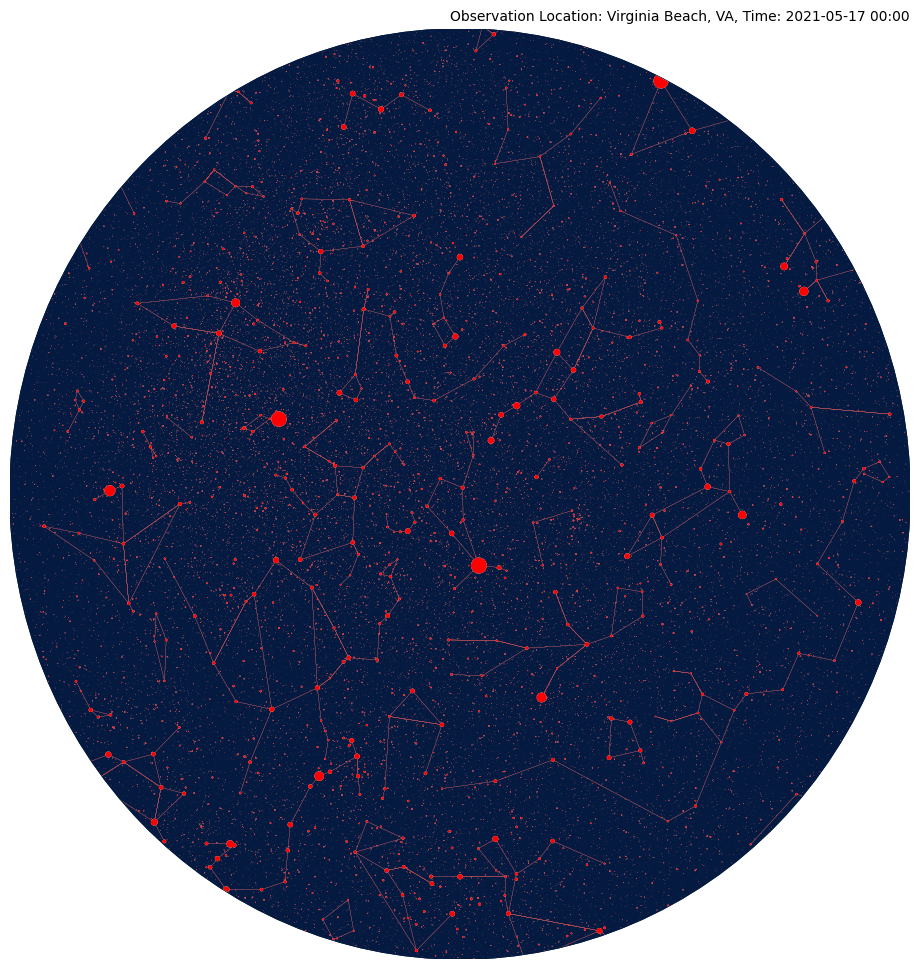

In [72]:
location = 'Virginia Beach, VA'
when = '2021-05-17 00:00'
chart_size=12
max_star_size=500
create_star_chart(location, when, chart_size, max_star_size)

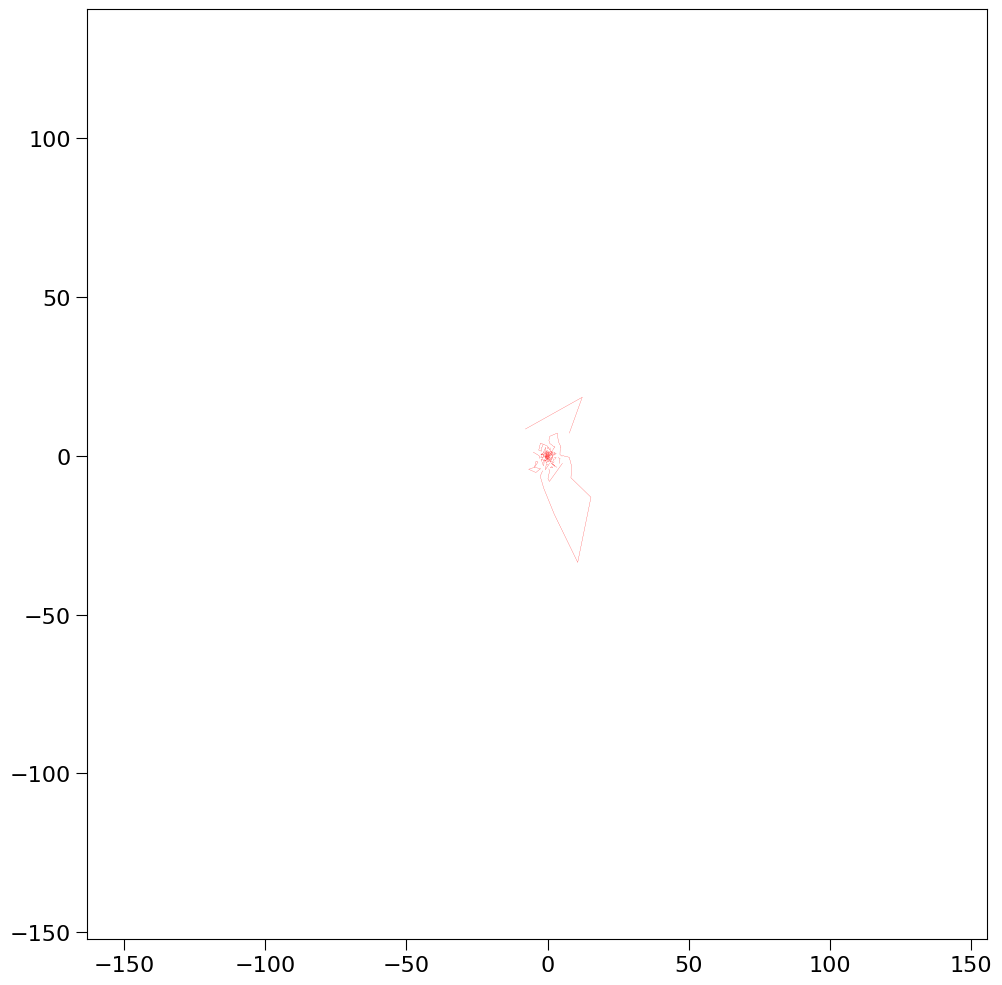

In [73]:
# create_star_chart(location, when, chart_size, max_star_size)
location, when, chart_size, max_star_size = location, when, chart_size, max_star_size
# def add_cam(location, when, chart_size, max_star_size):
stars, edges_star1, edges_star2 = collect_celestial_data(location, when)
limiting_magnitude = 10
bright_stars = (stars.magnitude <= limiting_magnitude)
magnitude = stars['magnitude'][bright_stars]
fig, ax = plt.subplots(figsize=(chart_size, chart_size))

#use the night sky color code
border = plt.Circle((0, 0), 1, color='#041A40', fill=True) 
ax.add_patch(border)

marker_size = max_star_size * 10 ** (magnitude / -2.5)

ax.scatter(stars['x'][bright_stars], stars['y'][bright_stars],
            s=marker_size, color='white', marker='.', linewidths=0,
            zorder=2)
# Draw the constellation lines.
xy1 = stars[['x', 'y']].loc[edges_star1].values
xy2 = stars[['x', 'y']].loc[edges_star2].values
lines_xy = np.rollaxis(np.array([xy1, xy2]), 1)

ax.add_collection(LineCollection(lines_xy, colors='red', linewidths=0.15))

In [74]:
stars

,magnitude,ra_degrees,dec_degrees,parallax_mas,ra_mas_per_year,dec_mas_per_year,ra_hours,epoch_year,x,y
hip,,,,,,,,,,
1,9.10,0.000912,1.089013,3.54,-5.20,-1.88,0.000061,1991.25,-1.618209,1.240201
2,9.27,0.003797,-19.498837,21.90,181.21,-0.93,0.000253,1991.25,-2.786578,0.808935
3,6.61,0.005008,38.859286,2.81,5.24,-2.91,0.000334,1991.25,-0.549274,0.972583
4,8.06,0.008382,-51.893546,7.75,62.85,0.16,0.000559,1991.25,-2.686339,-2.378055
5,8.55,0.009965,-40.591224,2.87,2.53,9.07,0.000664,1991.25,-3.479510,-1.222648
...,...,...,...,...,...,...,...,...,...,...
118318,6.99,359.963744,11.673709,1.92,-2.16,2.09,23.997583,1991.25,-1.204767,1.210357
118319,8.23,359.973913,-22.428180,10.63,148.74,27.53,23.998261,1991.25,-2.970997,0.638726
118320,7.59,359.976057,5.956638,5.00,20.92,-35.26,23.998404,1991.25,-1.413146,1.235906


In [75]:
edges_star1

[677,
 3092,
 5447,
 113726,
 116631,
 116805,
 116584,
 116805,
 116631,
 1473,
 2912,
 3092,
 2912,
 5447,
 4436,
 3881,
 5434,
 3092,
 3031,
 3693,
 53502,
 51172,
 72370,
 80047,
 81852,
 98036,
 97649,
 97278,
 95501,
 93805,
 95501,
 93747,
 95501,
 97804,
 93244,
 93805,
 99473,
 96468,
 93805,
 102618,
 106278,
 109074,
 110395,
 110960,
 111497,
 110960,
 110672,
 109139,
 106278,
 109074,
 110003,
 112961,
 114724,
 115033,
 115438,
 115033,
 114341,
 115033,
 113136,
 112716,
 85267,
 85727,
 82363,
 83081,
 83153,
 85792,
 88714,
 85792,
 8832,
 8903,
 9884,
 25428,
 23015,
 23767,
 24608,
 28360,
 28380,
 23767,
 23453,
 23416,
 24608,
 28358,
 69673,
 72105,
 74666,
 73555,
 71075,
 71053,
 69673,
 67927,
 69673,
 71075,
 69732,
 70497,
 69483,
 30324,
 32349,
 34444,
 33579,
 34444,
 30324,
 31592,
 33152,
 32349,
 33347,
 34045,
 33160,
 37279,
 63125,
 23595,
 21861,
 21770,
 23040,
 23522,
 22783,
 29997,
 33694,
 29997,
 22783,
 17959,
 17884,
 100064,
 100345,
 1024

In [76]:
edges_star2

[3092,
 5447,
 9640,
 116631,
 116805,
 116584,
 116805,
 116631,
 1473,
 2912,
 3092,
 2912,
 5447,
 4436,
 3881,
 5434,
 7607,
 3031,
 3693,
 4463,
 51172,
 46515,
 81065,
 81852,
 81065,
 97649,
 97278,
 95501,
 93805,
 95501,
 93747,
 95501,
 97804,
 99473,
 93747,
 93429,
 96468,
 93805,
 93747,
 106278,
 109074,
 110395,
 110960,
 111497,
 110960,
 110672,
 109074,
 106278,
 109074,
 110003,
 112961,
 114724,
 115033,
 115438,
 115033,
 114341,
 115033,
 113136,
 112716,
 112961,
 85727,
 82363,
 83081,
 83153,
 85792,
 88714,
 85792,
 85258,
 8903,
 9884,
 13209,
 23015,
 23767,
 24608,
 28360,
 28380,
 25428,
 23453,
 23416,
 24608,
 28358,
 28360,
 72105,
 74666,
 73555,
 71075,
 71053,
 69673,
 67927,
 67275,
 71795,
 69732,
 70497,
 69483,
 69732,
 32349,
 34444,
 33579,
 34444,
 35904,
 31592,
 33152,
 33579,
 33347,
 34045,
 33160,
 33347,
 36188,
 61317,
 21861,
 21770,
 21060,
 23522,
 22783,
 29997,
 33694,
 29997,
 22783,
 17959,
 17884,
 16228,
 100345,
 102485,
 1029